In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tab2img.converter import Tab2Img
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix,roc_curve, f1_score, ConfusionMatrixDisplay, PrecisionRecallDisplay,precision_score, recall_score, RocCurveDisplay

In [2]:
df = pd.read_parquet("processed_data/agg_data_preprocess_2.gzip")
target = pd.read_feather("train_labels.ftr")["target"]

In [3]:
agg_to_have = ["mean", "min", "max"]
columns_to_have = []

for col in df.columns:
    for agg in agg_to_have:
        if agg in col:
            columns_to_have.append(col)

len(columns_to_have)

462

In [4]:
df = df[columns_to_have]
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2)

In [12]:
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer


median_imputer = MeanMedianImputer(imputation_method='median')
median_imputer.fit(X_train)
X_train = median_imputer.transform(X_train)
X_test = median_imputer.transform(X_test)

In [64]:
X_train.shape

(367130, 462)

In [25]:
converter = Tab2Img(allow_pickle=True)
images = converter.fit_transform(X_train.values, y_train.values)
test_images = converter.transform(X_test.values)

In [32]:
import pickle
file = open("tab2imgconverter.pkl", "wb")
pickle.dump(converter, file)
file.close()

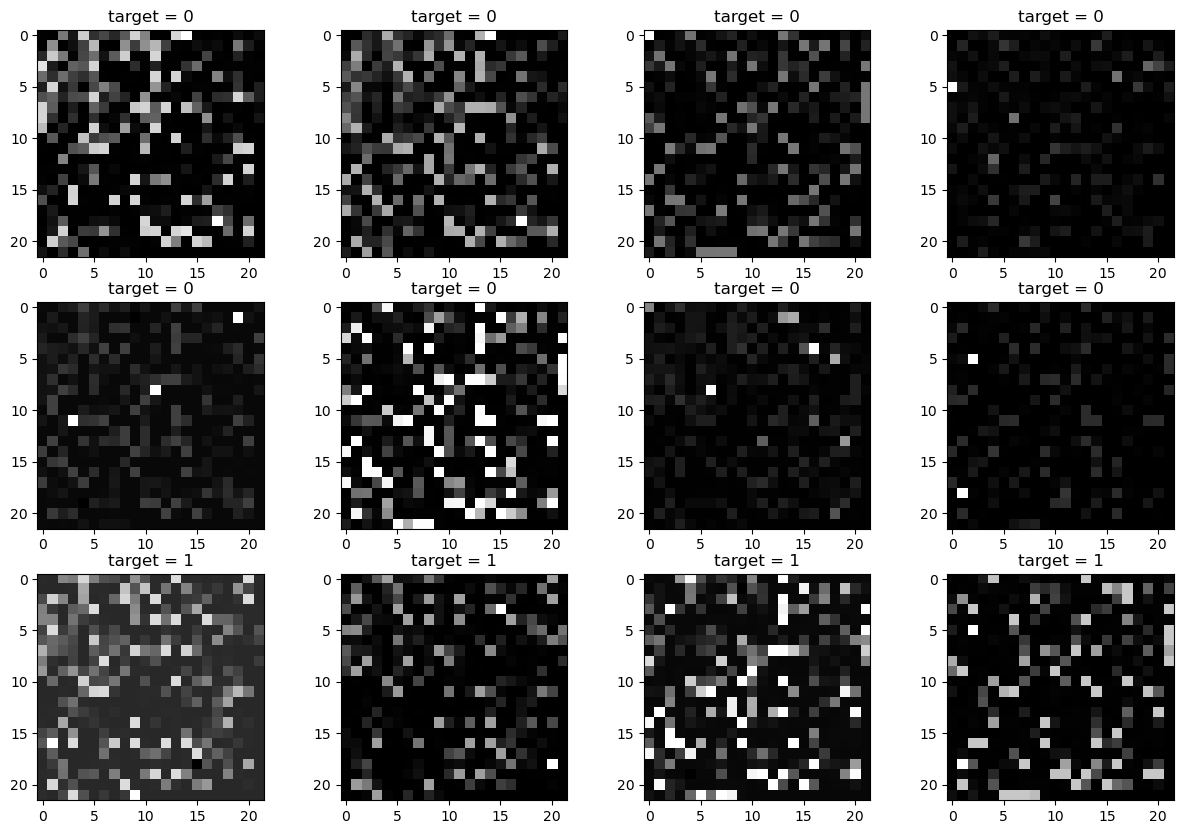

In [18]:
fig, ax = plt.subplots(3, 4, figsize=(15, 10))
ax = ax.flatten()
for i in range(12):
    ax[i].title.set_text(f"target = {target[i]}")
    ax[i].imshow(images[i], cmap = "gray")

plt.show()

In [19]:
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler

In [39]:
def build_model():

    input_layer = keras.Input(shape=(22, 22, 1))

    x = keras.layers.Conv2D(64, 5, strides=2, activation = "swish", padding="same")(input_layer)
    x = keras.layers.Conv2D(64, 3, strides=2, activation = "swish", padding="same")(x)
    x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    
    x = keras.layers.Conv2D(32, 5, strides=2, activation = "swish", padding="same")(x)
    x = keras.layers.Conv2D(32, 3, strides=2, activation = "swish", padding="same")(x)
    x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    
    # FC and predict
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(100,activation = "swish")(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(10,activation = "swish")(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [40]:
cnn_model = build_model()
cnn_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 22, 22, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 64)        1664      
                                                                 
 conv2d_17 (Conv2D)          (None, 6, 6, 64)          36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 3, 3, 64)         256       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 3, 3, 64)          0   

In [44]:
cnn_model.compile(
            loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Nadam(
                learning_rate=0.001, 
                clipvalue=0.5, 
                clipnorm=1.0
            ),
            metrics=["accuracy", "AUC"],
        )

In [46]:
history = cnn_model.fit(
            images,
            y_train,
            epochs=50,
            verbose=1,
            batch_size=1024,
        )

Epoch 1/50
359/359 [==============================] - 54s 150ms/step - loss: 0.2669 - accuracy: 0.8801 - auc: 0.9414
Epoch 2/50
359/359 [==============================] - 49s 136ms/step - loss: 0.2654 - accuracy: 0.8809 - auc: 0.9421
Epoch 3/50
359/359 [==============================] - 49s 135ms/step - loss: 0.2644 - accuracy: 0.8813 - auc: 0.9425
Epoch 4/50
359/359 [==============================] - 49s 136ms/step - loss: 0.2633 - accuracy: 0.8820 - auc: 0.9430
Epoch 5/50
359/359 [==============================] - 49s 136ms/step - loss: 0.2624 - accuracy: 0.8825 - auc: 0.9434
Epoch 6/50
359/359 [==============================] - 50s 139ms/step - loss: 0.2617 - accuracy: 0.8825 - auc: 0.9438
Epoch 7/50
359/359 [==============================] - 50s 140ms/step - loss: 0.2611 - accuracy: 0.8834 - auc: 0.9440
Epoch 8/50
359/359 [==============================] - 49s 138ms/step - loss: 0.2605 - accuracy: 0.8832 - auc: 0.9442
Epoch 9/50
359/359 [==============================] - 50s 138ms/

In [47]:
cnn_model.save("cnn_model.h5")

In [62]:
def display_metrics(predictor,y_true, y_pred_labels, y_pred_score):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    accuracy = accuracy_score(y_true, y_pred_labels)
    print("Accuracy: ", accuracy)
    precision = precision_score(y_true, y_pred_labels)
    print("Precision score: ", precision)
    recall = recall_score(y_true, y_pred_labels)
    print("Recall score: ", recall)
    f1 = f1_score(y_true, y_pred_labels)
    print("F1 score: ", f1)
    rocauc = roc_auc_score(y_true, y_pred_labels)
    print("roc_auc score: ", rocauc)
    conf_matrix = confusion_matrix(y_true, y_pred_labels)
    fpr, tpr, _ = roc_curve(y_true, y_pred_score)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax2)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=[0,1]).plot(ax=ax1)

11473/11473 [==============================] - 27s 2ms/step
Accuracy:  0.8982485767984093
Precision score:  0.8103735554958345
Recall score:  0.7926835679961304
F1 score:  0.8014309558487396
roc_auc score:  0.8639187702752636


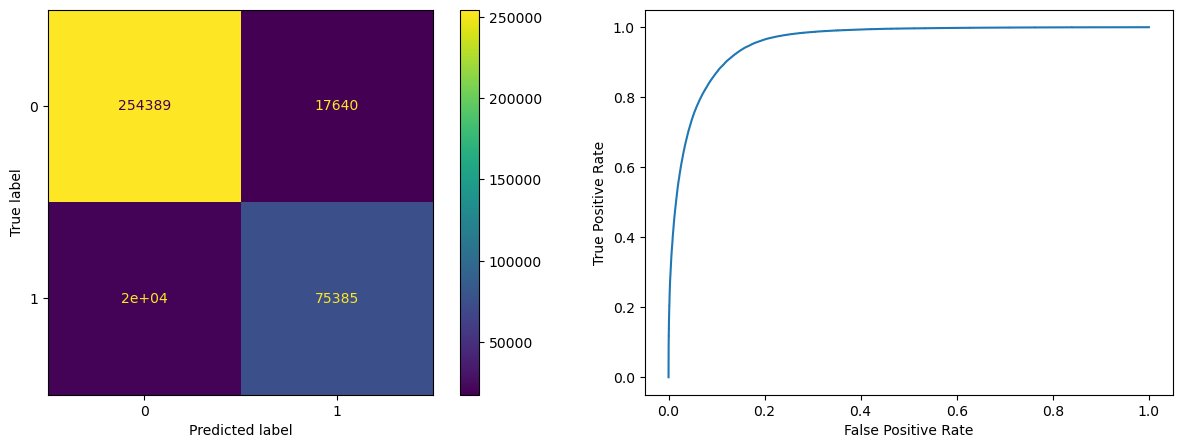

In [66]:
cnn_pred_train = cnn_model.predict(images)
cnn_pred_train_labels = cnn_pred_train.copy()
cnn_pred_train_labels[cnn_pred_train_labels >= 0.5] = 1
cnn_pred_train_labels[cnn_pred_train_labels < 0.5] = 0
display_metrics(cnn_model, y_train, cnn_pred_train_labels, cnn_pred_train)


Accuracy:  0.8855016724229977
Precision score:  0.785067287784679
Recall score:  0.7671007712732331
F1 score:  0.7759800473236554
roc_auc score:  0.8469408288010694


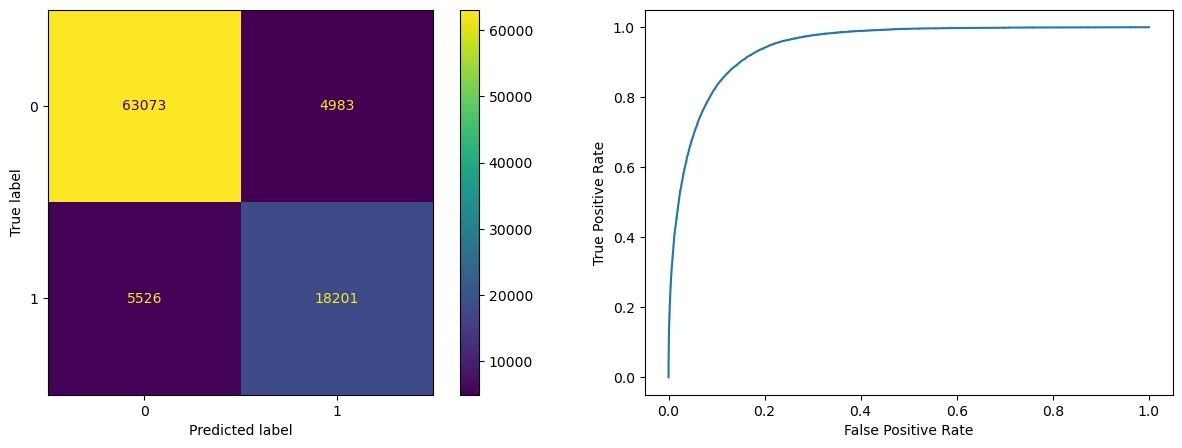

In [65]:
cnn_pred = cnn_model.predict(test_images)
cnn_pred_labels = cnn_pred.copy()
cnn_pred_labels[cnn_pred_labels >= 0.5] = 1
cnn_pred_labels[cnn_pred_labels < 0.5] = 0
display_metrics(cnn_model, y_test, cnn_pred_labels, cnn_pred)